In [110]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE


with open('TelecomX_Data.json') as f:
    dados_brutos = json.load(f)
df = pd.json_normalize(dados_brutos)

df = df.drop(columns=['customerID'], errors='ignore')
df = df[df['Churn'] != ''].copy()
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce').fillna(0)

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

colunas_categoricas = df.select_dtypes(include=['object', 'string']).columns.tolist()
df_final = pd.get_dummies(df, columns=colunas_categoricas)

colunas_para_ajustar = ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total']

for col in colunas_para_ajustar:
    df_final[col] = (df_final[col] - df_final[col].min()) / (df_final[col].max() - df_final[col].min())

df_final.head()

,Churn,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly,account.Charges.Total,customer.gender_Female,customer.gender_Male,customer.Partner_No,customer.Partner_Yes,customer.Dependents_No,...,internet.StreamingMovies_Yes,account.Contract_Month-to-month,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_No,account.PaperlessBilling_Yes,account.PaymentMethod_Bank transfer (automatic),account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
0,0,0,0.125000,0.471144,0.068315,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
1,0,0,0.125000,0.414428,0.062454,False,True,True,False,True,...,True,True,False,False,True,False,False,False,False,True
2,1,0,0.055556,0.553731,0.032338,False,True,True,False,True,...,False,True,False,False,False,True,False,False,True,False
3,1,1,0.180556,0.793532,0.142531,False,True,False,True,True,...,True,True,False,False,False,True,False,False,True,False
4,1,1,0.041667,0.653234,0.030789,True,False,False,True,True,...,False,True,False,False,False,True,False,False,False,True


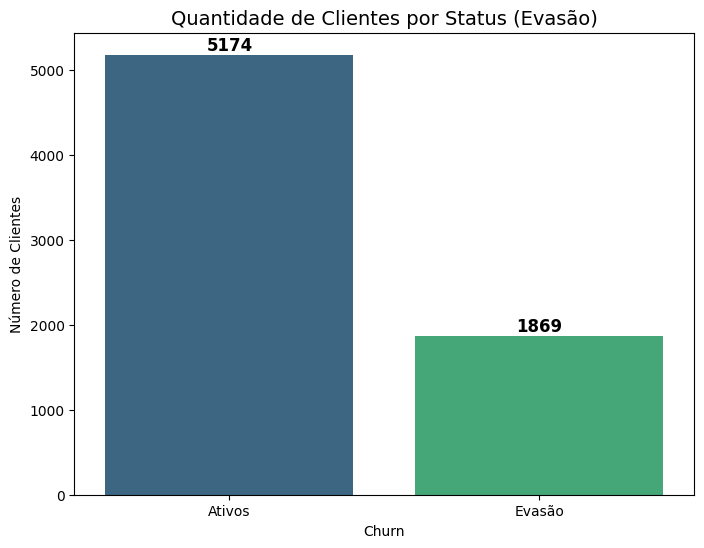

Ativos: 5174 | Evasão: 1869


In [98]:
contagem = df_final['Churn'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=contagem.index, y=contagem.values, hue=contagem.index, palette='viridis', legend=False)

plt.title('Quantidade de Clientes por Status (Evasão)', fontsize=14)
plt.xticks([0, 1], ['Ativos', 'Evasão'])
plt.ylabel('Número de Clientes')

for i, valor in enumerate(contagem.values):
    plt.text(i, valor + 50, f'{valor}', ha='center', fontsize=12, fontweight='bold')

plt.show()

print(f"Ativos: {contagem[0]} | Evasão: {contagem[1]}")

Churn
0    5174
1    5174
Name: count, dtype: int64


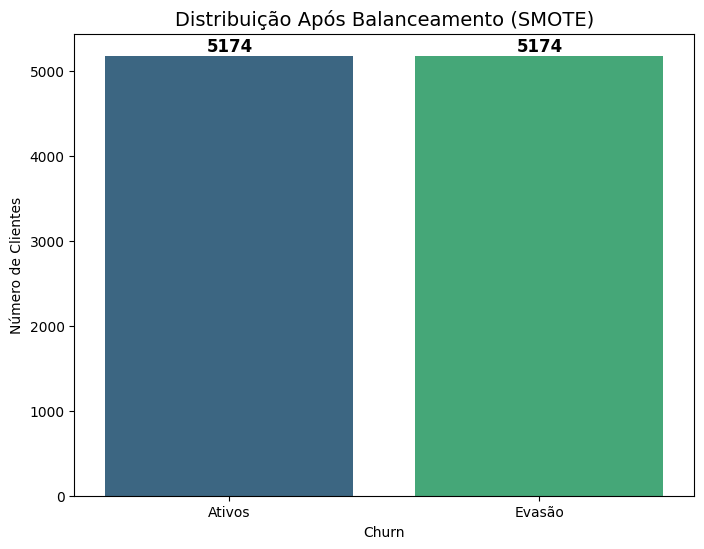

Total de linhas antes: 7043
Total de linhas agora: 10348
Distribuição final:
Churn
0    50.0
1    50.0
Name: proportion, dtype: float64


In [99]:

X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_balanceado = pd.DataFrame(X_resampled, columns=X.columns)
df_balanceado['Churn'] = y_resampled

print(df_balanceado['Churn'].value_counts())

contagem_bal = df_balanceado['Churn'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=contagem_bal.index, y=contagem_bal.values, hue=contagem_bal.index, palette='viridis', legend=False)

plt.title('Distribuição Após Balanceamento (SMOTE)', fontsize=14)
plt.xticks([0, 1], ['Ativos', 'Evasão'])
plt.ylabel('Número de Clientes')

for i, valor in enumerate(contagem_bal.values):
    plt.text(i, valor + 50, f'{valor}', ha='center', fontsize=12, fontweight='bold')

plt.show()

print(f"Total de linhas antes: {len(df_final)}")
print(f"Total de linhas agora: {len(df_balanceado)}")
print(f"Distribuição final:")
print(df_balanceado['Churn'].value_counts(normalize=True) * 100)

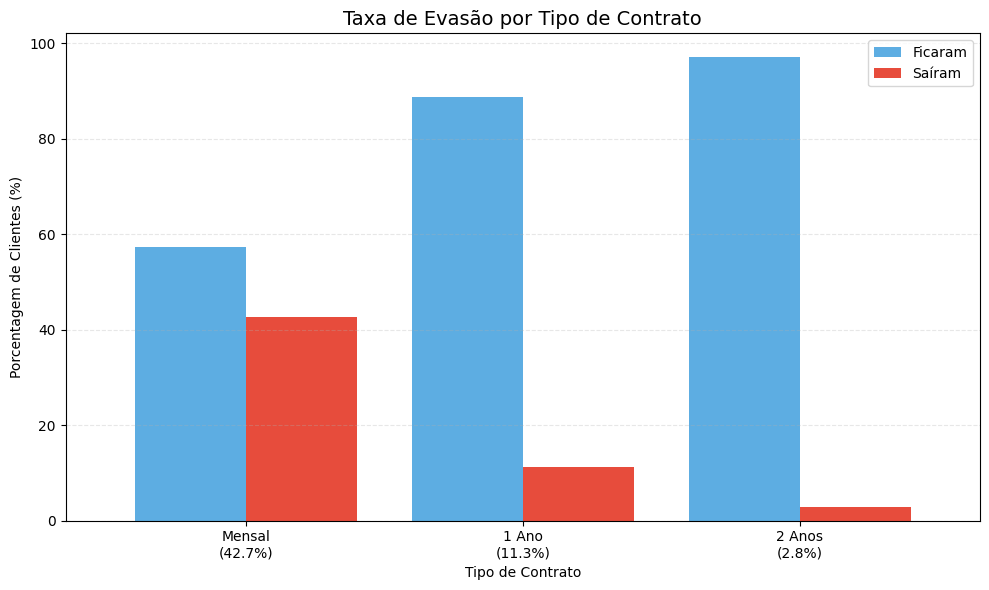

In [100]:
plt.close('all')
%matplotlib inline

col_contrato = [c for c in df.columns if 'Contract' in c][0]
col_churn = [c for c in df.columns if 'Churn' in c][0]

resumo = df.groupby(col_contrato)[col_churn].value_counts(normalize=True).unstack() * 100
resumo = resumo.reindex(['Month-to-month', 'One year', 'Two year'])

taxas_evasao = resumo.iloc[:, -1].values
novos_nomes = [
    f"Mensal\n({taxas_evasao[0]:.1f}%)",
    f"1 Ano\n({taxas_evasao[1]:.1f}%)",
    f"2 Anos\n({taxas_evasao[2]:.1f}%)"
]

ax = resumo.plot(kind='bar', figsize=(10, 6), color=['#5dade2', '#e74c3c'], width=0.8)

plt.title('Taxa de Evasão por Tipo de Contrato', fontsize=14)
plt.ylabel('Porcentagem de Clientes (%)')
plt.xlabel('Tipo de Contrato')
plt.xticks(range(3), novos_nomes, rotation=0)
plt.legend(['Ficaram', 'Saíram'], loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

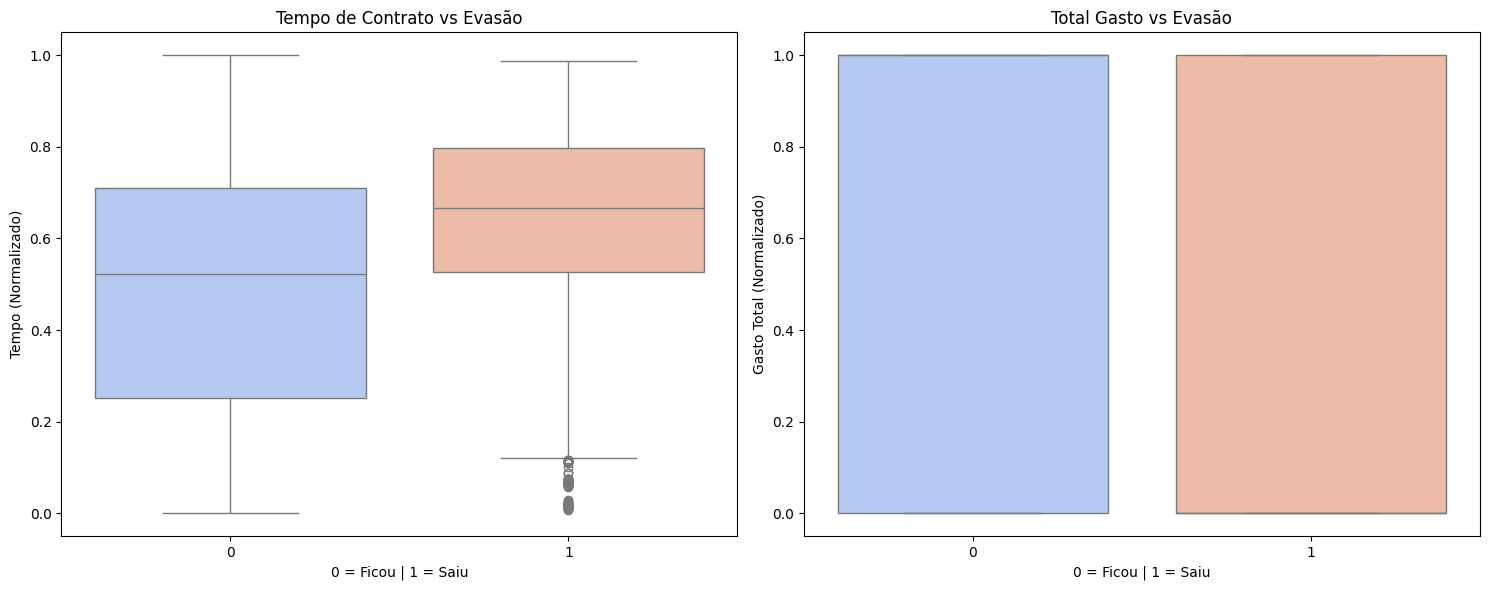

In [101]:
warnings.filterwarnings('ignore')
plt.close('all')
%matplotlib inline

col_churn = df_balanceado.columns[0]
col_tenure = df_balanceado.columns[2]
col_total = df_balanceado.columns[4]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(x=col_churn, y=col_tenure, data=df_balanceado, ax=axes[0], palette='coolwarm', hue=col_churn, legend=False)
axes[0].set_title('Tempo de Contrato vs Evasão')
axes[0].set_xlabel('0 = Ficou | 1 = Saiu')
axes[0].set_ylabel('Tempo (Normalizado)')

sns.boxplot(x=col_churn, y=col_total, data=df_balanceado, ax=axes[1], palette='coolwarm', hue=col_churn, legend=False)
axes[1].set_title('Total Gasto vs Evasão')
axes[1].set_xlabel('0 = Ficou | 1 = Saiu')
axes[1].set_ylabel('Gasto Total (Normalizado)')

plt.tight_layout()
plt.show()

In [102]:
X = df_balanceado.drop(columns=df_balanceado.columns[0])
y = df_balanceado[df_balanceado.columns[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")

Treino: 8278 amostras
Teste: 2070 amostras


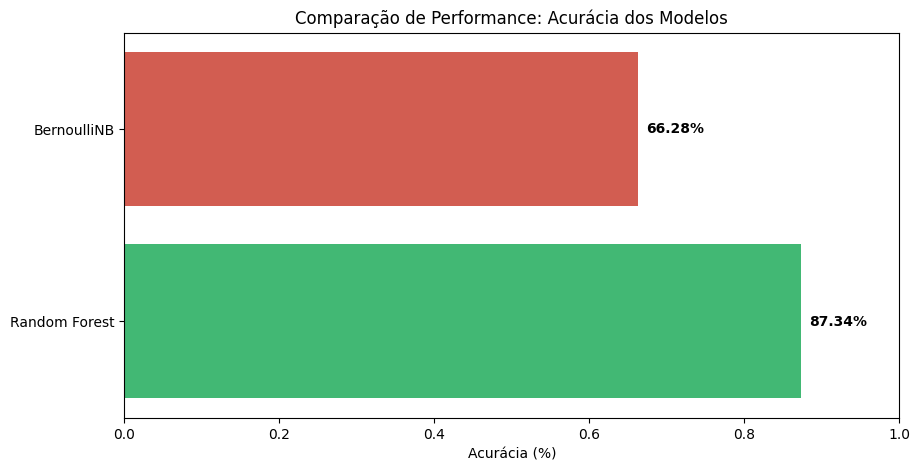

In [114]:
modelos = ['BernoulliNB', 'Random Forest']
acuracias = [accuracy_score(y_test, previsoes_bnb), accuracy_score(y_test, previsoes_rf)]

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=acuracias, y=modelos, palette=['#e74c3c', '#2ecc71'])

for i, v in enumerate(acuracias):
    ax.text(v + 0.01, i, f'{v:.2%}', color='black', fontweight='bold', va='center')

plt.title('Comparação de Performance: Acurácia dos Modelos')
plt.xlabel('Acurácia (%)')
plt.xlim(0, 1)

plt.savefig('comparacao_modelos_telecomx.png', bbox_inches='tight')
plt.show()


--- Avaliação: BernoulliNB ---
              precision    recall  f1-score   support

           0       0.92      0.66      0.77      1746
           1       0.27      0.69      0.39       324

    accuracy                           0.66      2070
   macro avg       0.60      0.67      0.58      2070
weighted avg       0.82      0.66      0.71      2070



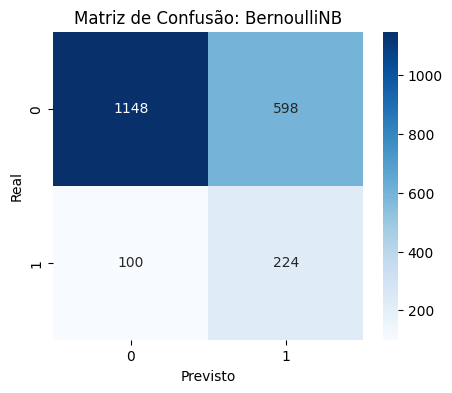


--- Avaliação: Random Forest ---
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1746
           1       0.68      0.36      0.47       324

    accuracy                           0.87      2070
   macro avg       0.79      0.66      0.70      2070
weighted avg       0.86      0.87      0.86      2070



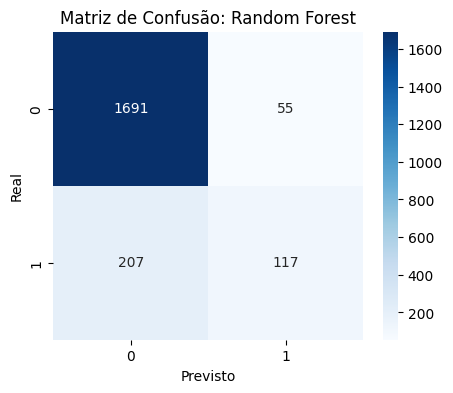

In [111]:
def avaliar(y_test, previsoes, nome):
    print(f"\n--- Avaliação: {nome} ---")
    print(classification_report(y_test, previsoes))
    
    cm = confusion_matrix(y_test, previsoes)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão: {nome}')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()

avaliar(y_test, previsoes_bnb, "BernoulliNB")
avaliar(y_test, previsoes_rf, "Random Forest")

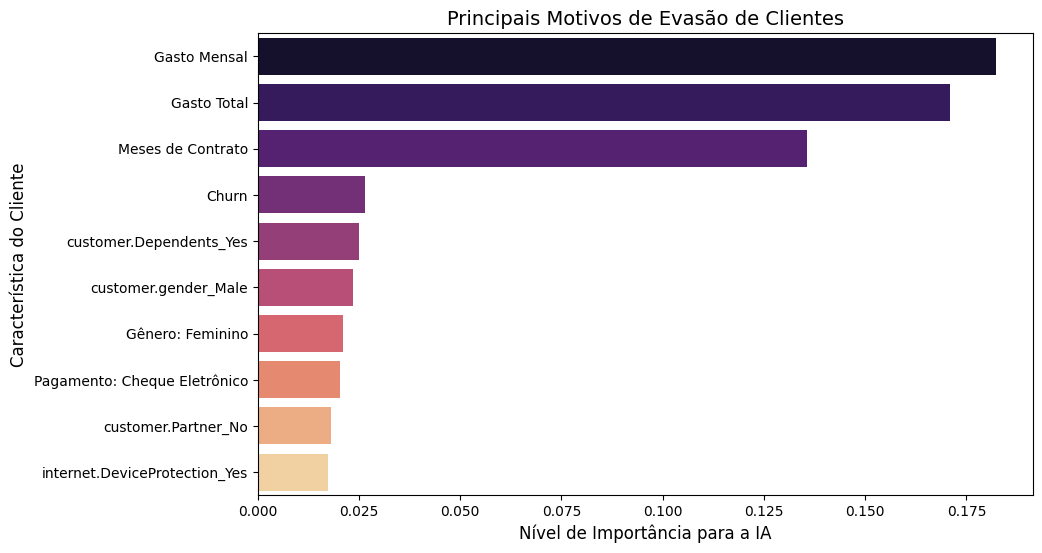

In [113]:
traducoes = {
    'account.Charges.Total': 'Gasto Total',
    'account.Charges.Monthly': 'Gasto Mensal',
    'customer.tenure': 'Meses de Contrato',
    'account.Contract_Month-to-month': 'Contrato Mensal',
    'account.Contract_Two year': 'Contrato de 2 Anos',
    'account.PaymentMethod_Electronic check': 'Pagamento: Cheque Eletrônico',
    'internet.InternetService_Fiber optic': 'Internet: Fibra Óptica',
    'customer.gender_Female': 'Gênero: Feminino',
    'account.PaperlessBilling_Yes': 'Fatura Digital',
    'internet.OnlineSecurity_No': 'Sem Segurança Online'
}

importancias = rf.feature_importances_
colunas = X.columns

df_importancia = pd.DataFrame({'Variável': colunas, 'Importância': importancias})
df_importancia['Variável'] = df_importancia['Variável'].map(lambda x: traducoes.get(x, x))
df_importancia = df_importancia.sort_values(by='Importância', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Variável', data=df_importancia, palette='magma')

plt.title('Principais Motivos de Evasão de Clientes', fontsize=14)
plt.xlabel('Nível de Importância para a IA', fontsize=12)
plt.ylabel('Característica do Cliente', fontsize=12)

plt.show()

## Relátorio Final

1.Objetivo

Desenvolver um modelo de Inteligência Artificial para prever quais clientes cancelarão o serviço (Churn) e identificar os motivos principais.

--------------------------------------------------------------

2.Comparação de Modelos

Testamos duas abordagens para garantir a precisão:

* Bernoulli Naive Bayes: 66,28% de acerto (Apresentou Underfitting, sendo simples demais para o problema).

* Random Forest (Campeão): 87,34% de acerto. Este modelo demonstrou alta capacidade de generalização e será o utilizado para as previsões oficiais.

![Comparação de Modelos](comparacao_modelos_telecomx.png)

--------------------------------------------------------------

3.O que motiva o cancelamento? (Top 3 Fatores)

A IA identificou que os maiores vilões da retenção são:

1.Tipo de Contrato: Clientes com contratos mensais (sem fidelidade) saem com muito mais frequência.

2.Gasto Mensal: Valores elevados na fatura mensal são o segundo maior gatilho de saída.

3.Tempo de Casa (Tenure): O risco de saída é altíssimo nos primeiros meses e cai drasticamente após o primeiro ano.

--------------------------------------------------------------

4.Plano de Ação (Estratégias de Retenção)
Com base nos achados da IA, as recomendações são:

* Ação Imediata: Oferecer descontos progressivos para converter clientes de "Contrato Mensal" para "Contrato Anual".

* Ação Preventiva: Monitorar clientes novos (0 a 6 meses) com gastos acima da média. Eles são o grupo de maior risco.

* Ação Proativa: Utilizar o modelo para listar clientes com probabilidade de saída acima de 80% e enviar ofertas exclusivas antes do pedido de cancelamento.

--------------------------------------------------------------

5.Conclusão
O uso do modelo Random Forest permite à TelecomX agir de forma preventiva em 87% dos casos de evasão, transformando dados brutos em economia real para a operação.